In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import ase.io as aio
import scipy.io as sio
import glob

from toolz.curried import pipe, curry

import atomistics as amks

import scipy.ndimage.morphology as morph
import scipy.ndimage.measurements as measure

from skimage.morphology import skeletonize_3d as sklz

import skimage.measure as skmeasure
import skimage.morphology as skmorph

you can install PyFFTW for speed-up as - 
conda install -c conda-forge pyfftw


In [3]:
from ase.neighborlist import neighbor_list

In [4]:
from ase import Atoms
from sklearn.neighbors import KernelDensity
import pandas as pd
import numpy.fft as mf
from scipy.spatial.distance import cdist
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from sklearn.decomposition import PCA
import multiprocessing

In [5]:
import numpy.fft as mf

def epanechnikov(u, h):
    p = 0.75 * (5**(-0.5)) * (1 - (u**2) / (5 * h**2)) / h
    p[p<0] = 0
    return p

def mk_kernel(width, x):
    steps = x[1:] - x[:-1]
    width = width/np.sqrt(5)

    if not np.all(np.isclose(steps[0], steps)):
        raise ValueError('Bins need to be same width!')
        return None

    k_half = int((np.sqrt(5)*width)//steps[0] + 1)
    u = np.linspace(-k_half*steps[0],k_half*steps[0],k_half*2+1)

    kernel = epanechnikov(u=u, h=width)
    shift_to_mid = -len(kernel)//2 + 1
    kernel_arr = np.zeros(len(x))
    kernel_arr[:len(kernel)] = kernel
    kernel_arr = np.roll(kernel_arr, shift_to_mid)
    return kernel_arr

def conv_kernel(kern_arr, p):
    h1 = mf.fftn(kern_arr)
    h2 = mf.fftn(p)
    density = mf.ifftn(h1.conj() * h2).real
    return density

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

In [7]:
distance_transform = morph.distance_transform_edt

In [15]:
def return_rdfs(atom, cutoff_=5.0):
    syms = np.asarray(atom.get_chemical_symbols())
    idx_o = np.where(syms == 'O')[0]
    idx_s = np.where(syms == 'Si')[0]

    bins = np.linspace(0.0, cutoff_ + 2, 501)

    i, j, d, D = neighbor_list('ijdD', atom, cutoff=cutoff_, self_interaction=True)

    rdf_list = []

    _auxset = set(idx_o)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    pdf = h / len(idx_o)
    rdf_list.append(pdf)

    _auxset = set(idx_s)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    pdf = h / len(idx_s)
    rdf_list.append(pdf)

    _auxset = set(idx_s)
    d_list = []
    for idx in idx_o:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]

    h, bin_edges = np.histogram(d_list, bins)

    pdf = h / len(idx_o)
    rdf_list.append(pdf)
    
    return rdf_list, bin_edges

In [9]:
def get_pdf(fname, bins, cutoff=5):
    atom = pipe(fname, 
                lambda cif: aio.read(fname), 
                lambda x: x.repeat([2, 2, 2]))
    
    rdf_list = compute_rdf(atom, bins, cutoff)
    bin_centers = bins[:-1] + (bins[1] - bins[0]) * 0.5 

    pdf_list = []
    pdf_list = pdf_list + list((rdf_list[0]))
    pdf_list = pdf_list + list((rdf_list[1]))
    pdf_list = pdf_list + list((rdf_list[2]))
    pdf_list = np.array(pdf_list)
    
    sing_kernel = mk_kernel(width=0.10, x=bin_centers)
    
    new_pdf_list = []
    new_pdf_list = new_pdf_list + list(conv_kernel(sing_kernel, (rdf_list[0])))
    new_pdf_list = new_pdf_list + list(conv_kernel(sing_kernel, (rdf_list[1])))
    new_pdf_list = new_pdf_list + list(conv_kernel(sing_kernel, (rdf_list[2])))
    new_pdf_list = np.array(new_pdf_list)
    
    return pdf_list, new_pdf_list

In [10]:
flist = sorted(glob.glob("../data/input3dSlabs/*.cif"))
n_list = len(flist)
pdf_list, new_pdf_list = np.zeros([n_list, 600]), np.zeros([n_list, 600])

In [12]:
bins = np.linspace(0, 10, 501)

In [16]:
fname = flist[0]
get_pdf(fname, bins, cutoff=5)

NameError: name 'compute_rdf' is not defined

In [14]:
for indx, fname in enumerate(flist):
    print(fname)
    pdf_list[indx,:], new_pdf_list[indx,:] = get_pdf(fname, bins, cutoff=5)

../data/input3dSlabs/ABW.cif


NameError: name 'compute_rdf' is not defined

In [415]:
pdf_list.shape

(231, 600)

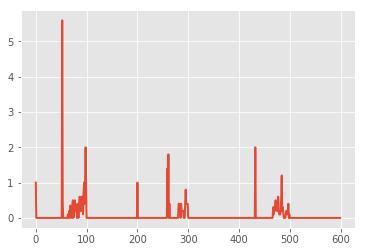

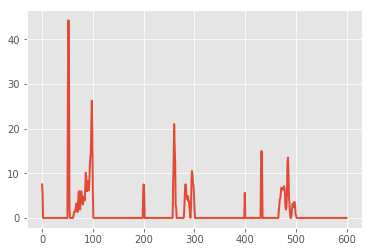

In [416]:
index = 220
plt.plot(pdf_list[index])
plt.show()
plt.plot(new_pdf_list[index])
plt.show()

In [399]:
from sklearn.decomposition import PCA

In [423]:
%%time
pca = PCA(n_components=100)
pc_scores = pca.fit_transform(pdf_list)

CPU times: user 65.8 ms, sys: 0 ns, total: 65.8 ms
Wall time: 41.9 ms


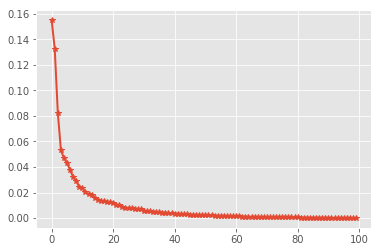

In [424]:
plt.plot(pca.explained_variance_ratio_, '-*')
plt.show()

**Computation of FCC RDF using neighbor_list not taking into account periodicity**

In [3]:
from ase.lattice.cubic import FaceCenteredCubic
import numpy as np

In [4]:
atoms = FaceCenteredCubic(directions=[[1,-1,0], [1,1,-2], [1,1,1]], 
                          size=(6,6,6), symbol='Cu', pbc=(1,1,1))
bins = np.linspace(0, 10, 501)
coords = atoms.get_positions()
print(coords.shape)

(1296, 3)


In [31]:
%%time
dmap = np.ravel(cdist(coords, coords))

CPU times: user 574 ms, sys: 268 ms, total: 842 ms
Wall time: 841 ms


In [35]:
%%time
pdf, bin_edges = np.histogram(dmap, bins)
pdf = pdf / len(coords)

CPU times: user 7.04 s, sys: 0 ns, total: 7.04 s
Wall time: 7.03 s


In [37]:
bin_centers = bin_edges[:-1] + (bin_edges[1:] - bin_edges[:-1])/2

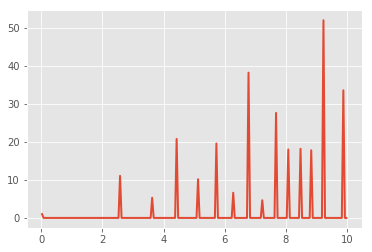

In [38]:
plt.plot(bin_centers, pdf)
plt.show()

**Computation of RDF using neighbor_list taking into account periodicity**

In [79]:
atoms = aio.read("../data/input3dSlabs/MFI.cif")

In [69]:
pbc = (True, True, True)
atoms.set_pbc(pbc)
atoms.get_pbc()

In [134]:
def compute_rdf_ase(atom, bins):
    a = atom.copy()
    N = len(a)
    i, j, d, D = neighbor_list('ijdD', a, cutoff=10.0, self_interaction=True)
    h, bin_edges = np.histogram(d, bins)
    rdf = h / N
    return rdf

In [335]:
def compute_rdf(atom, bins, cutoff=6):   
    syms  = np.asarray(atom.get_chemical_symbols())
    idx_o = np.where(syms == 'O')[0]
    idx_s = np.where(syms == 'Si')[0]
    i, j, d, D = neighbor_list('ijdD', atom, cutoff=cutoff, self_interaction=True)
    rdf_list = []
    _auxset = set(idx_o)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]
    h = np.histogram(d_list, bins)[0]
    rdf_list.append(h / len(_auxset))

    _auxset = set(idx_s)
    d_list = []
    for idx in _auxset:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]
    h = np.histogram(d_list, bins)[0]
    rdf_list.append(h / len(_auxset))

    _auxset = set(idx_s)
    d_list = []
    for idx in idx_o:
        a = list(j[np.where(i == idx)[0]])
        b = list(d[np.where(i == idx)[0]])
        d_list = d_list + [b[a.index(x)] for x in a if x in _auxset]
    h = np.histogram(d_list, bins)[0]
    rdf_list.append(h / len(idx_o))

    return rdf_list

In [172]:
def compute_rho(atom):
    N = len(atom)
    vol = np.prod(atom.get_cell().diagonal())
    return N / vol

In [175]:
print(compute_rho(aio.read("../data/input3dSlabs/MFI.cif")))
print(compute_rho(aio.read("../data/input3dSlabs/ABW.cif")))
print(compute_rho(aio.read("../data/input3dSlabs/EDI.cif")))
print(compute_rho(aio.read("../data/input3dSlabs/MWW.cif")))
print(compute_rho(aio.read("../data/input3dSlabs/TUN.cif")))

0.05526471612115999
0.05275607085608738
0.0487829719829366
0.04780083245896116
0.052823835517652976


In [155]:
rdf_mfi = compute_rdf_ase(aio.read("../data/input3dSlabs/MFI.cif"), 
                          bins)
rdf_tun = compute_rdf_ase(aio.read("../data/input3dSlabs/TUN.cif"), 
                          bins)
rdf_abw = compute_rdf_ase(aio.read("../data/input3dSlabs/ABW.cif"), 
                          bins)

rdf_edi = compute_rdf_ase(aio.read("../data/input3dSlabs/EDI.cif"), 
                          bins)

In [ ]:
rdf_abw = compute_rdf(a)

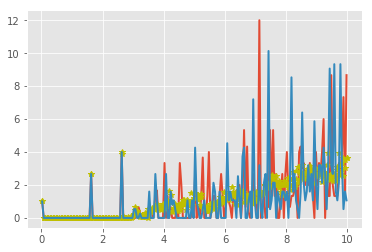

In [166]:
plt.plot(bin_centers, rdf_abw)
plt.plot(bin_centers, rdf_mfi, "*y")
plt.plot(bin_centers, rdf_tun, "*y")
plt.plot(bin_centers, rdf_edi)
plt.show()

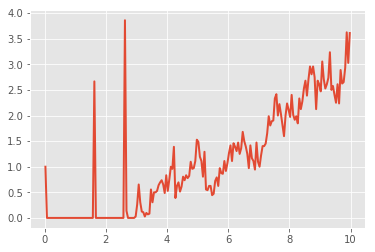

CPU times: user 2.11 s, sys: 19.4 ms, total: 2.13 s
Wall time: 1.06 s


In [78]:
%%time
a = atoms.copy()
N = len(a)

i, j, d, D = neighbor_list('ijdD', a, cutoff=10.0, self_interaction=True)

h, bin_edges = np.histogram(d, bins)

pdf = h / N

plt.plot(bin_centers, pdf)
plt.show()

**Computation of RDF for MFI using neighbor_list taking into account periodicity**

[[20.09   0.     0.   ]
 [ 0.    19.738  0.   ]
 [ 0.     0.    13.142]]
Orthogonal Unit Cell: True
192
96
192


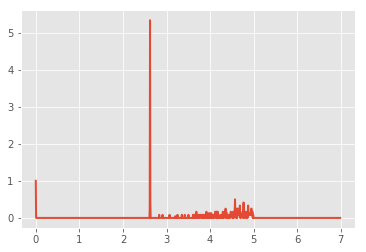

96


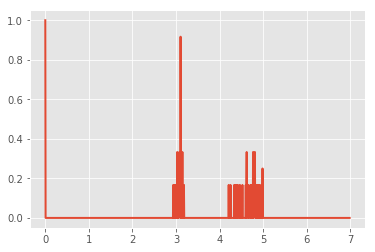

CPU times: user 1.22 s, sys: 39.4 ms, total: 1.26 s
Wall time: 483 ms


In [22]:
%%time
cif = "MFI"
atom = pipe(cif, 
            lambda cif: aio.read("../data/input3dSlabs/%s.cif" % cif), 
            lambda x: x.repeat([1, 1, 1]))

print(atom.get_cell())
print("Orthogonal Unit Cell:", np.all(atom.get_cell_lengths_and_angles()[3:] == 90.0))

syms = np.asarray(atom.get_chemical_symbols())
idx_o = np.where(syms == 'O')[0]
idx_s = np.where(syms == 'Si')[0]

coords = atom.get_positions()
coords_o = coords[idx_o]
coords_s = coords[idx_s]

cell = atom.get_cell()

N_o = len(idx_o)
N_s = len(idx_s)

pbc = atom.get_pbc()

atom_o = Atoms(positions=coords_o, 
               cell=cell, pbc=pbc, 
               symbols=['O']*N_o)

atom_s = Atoms(positions=coords_s, 
               cell=cell, pbc=pbc, 
               symbols=['Si']*N_s)

print(N_o)
print(N_s)


cutoff_ = 5
bins = np.linspace(0.0, cutoff_ + 2, 1001)

a = atom_o
N = len(a)
print(N)
i, j, d, D = neighbor_list('ijdD', a, cutoff=cutoff_, self_interaction=True)

h, bin_edges = np.histogram(d, bins)

pdf = h / N

d_bin = (bin_edges[1] - bin_edges[2]) / 2
bin_centers = bin_edges[:-1] + d_bin

plt.plot(bin_centers, pdf)
plt.show()

a = atom_s
N = len(a)
print(N)
i, j, d, D = neighbor_list('ijdD', a, cutoff=cutoff_, self_interaction=True)

h, bin_edges = np.histogram(d, bins)

pdf = h / N

d_bin = (bin_edges[1] - bin_edges[2]) / 2
bin_centers = bin_edges[:-1] + d_bin

plt.plot(bin_centers, pdf)
plt.show()

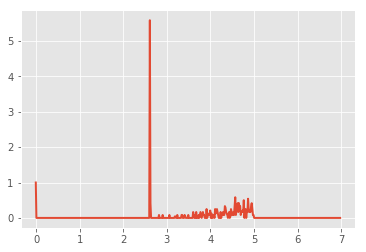

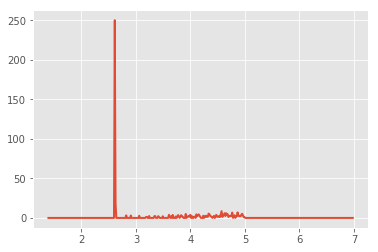

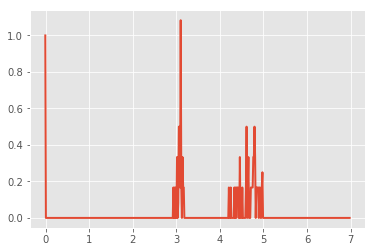

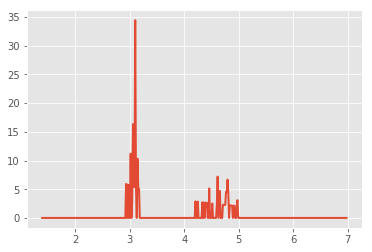

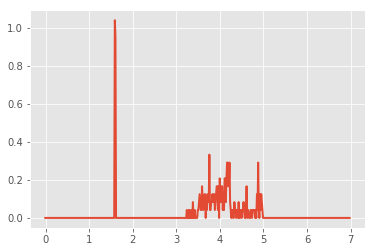

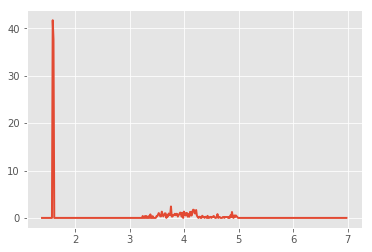

510.72896169955135
220.12484804489372
134.5954814484108


In [24]:
cif = "MFI"
atom = pipe(cif, 
            lambda cif: aio.read("../data/input3dSlabs/%s.cif" % cif), 
            lambda x: x.repeat([1, 1, 1]))
rdf_list, bin_edges = return_rdfs(atom)
d_bin = (bin_edges[1] - bin_edges[2]) / 2
bin_centers = bin_edges[:-1] + d_bin

idx_o = np.array(a.get_chemical_symbols()) == 'O'
idx_s = np.array(a.get_chemical_symbols()) == 'Si'

vols = np.pi * 4 / 3 * (bin_edges[1:]**3 - bin_edges[:-1]**3)
rho0 = len(idx_o) / np.prod(atom.get_cell().diagonal())
rho1 = len(idx_s) / np.prod(atom.get_cell().diagonal())
rho2 = len(atom) / np.prod(atom.get_cell().diagonal())

plt.plot(bin_centers, rdf_list[0])
plt.show()
plt.plot(bin_centers[100:], (rdf_list[0] / (vols * rho0))[100:])
plt.show()


plt.plot(bin_centers, rdf_list[1])
plt.show()
plt.plot(bin_centers[100:], (rdf_list[1] / (vols * rho1))[100:])
plt.show()


plt.plot(bin_centers, rdf_list[2])
plt.show()
plt.plot(bin_centers[100:], (rdf_list[2] / (vols * rho2))[100:])
plt.show()



print(np.sum((rdf_list[0] / (vols * rho0))[100:]))
print(np.sum((rdf_list[1] / (vols * rho1))[100:]))
print(np.sum((rdf_list[2] / (vols * rho2))[100:]))

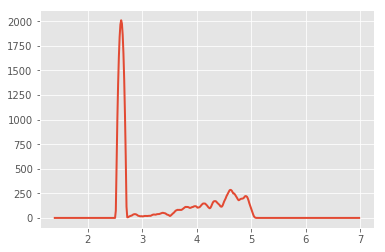

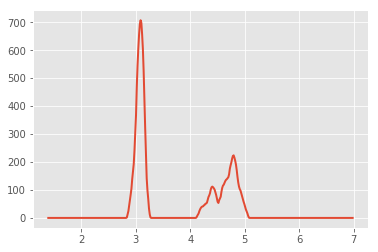

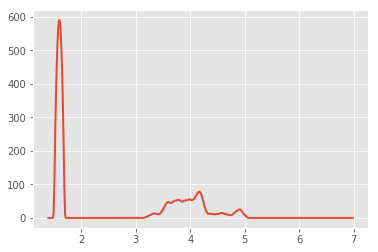

In [25]:
sing_kernel = mk_kernel(width=0.10, x=bin_centers[100:])
new_pdf0 = conv_kernel(sing_kernel, (rdf_list[0] / (vols * rho0))[100:])
new_pdf1 = conv_kernel(sing_kernel, (rdf_list[1] / (vols * rho1))[100:])
new_pdf2 = conv_kernel(sing_kernel, (rdf_list[2] / (vols * rho2))[100:])

plt.plot(bin_centers[100:], new_pdf0)
plt.show()
plt.plot(bin_centers[100:], new_pdf1)
plt.show()
plt.plot(bin_centers[100:], new_pdf2)
plt.show()